# Homework 2

##### Deadline for submission of your solutions is **28th of November**.

* Same instructions as in Homework 1 apply here. 
$\newcommand{\dx}{\,\mathrm{d}x}$

## Problem 1 (Finite Difference Method in 2D)

 **a)** Let $\Omega = [0,1]\times [0,1]$.
For the functions $u_k(x,y) = \sin(2 \pi k x) \sin(2 \pi k y)$ with frequency $k \in \mathbb{N}$,
compute the right-hand side $f$ and boundary data $g$
such that $u_k$ satisfies the Poisson problem
\begin{align*}
- \Delta u_k  &= f \quad \text{in } \Omega,
\\
 u_k &= g \quad \text{on } \partial \Omega.
\end{align*}

**b)** Based on the code snippets below, implement a finite difference scheme to solve this Poisson problem numerically. For the computational grid, assume equally spaced subdivisions in $x$ and $y$ direction, starting with $N=8$ subintervals. For $N = 8, 16, 32, 64$, compute and plot the finite difference solution $U$.

### Answer

**a)** Given $u_k(x,y) = \sin(2 \pi k x) \sin(2 \pi k y)$ and that $k$ is an integer we get that
$$
f(x) = 8 \pi^2 k^2 \sin(2 \pi k x) \sin(2 \pi k y)
$$
and $g(x) = 0$.


**b)** Using $k=2$

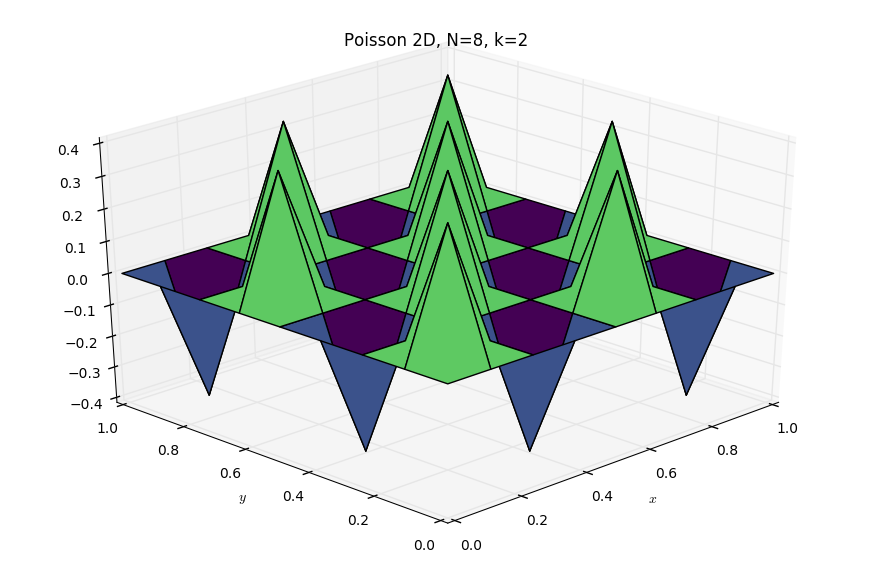

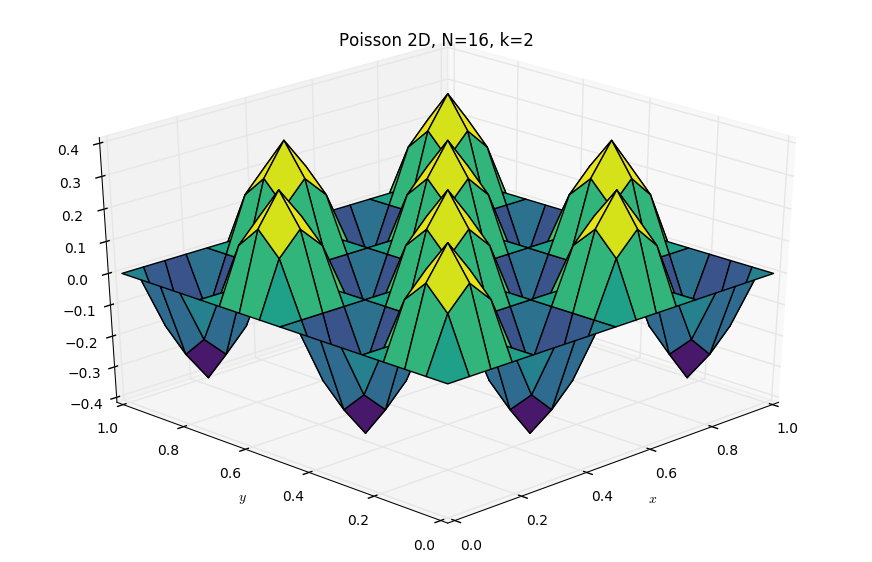

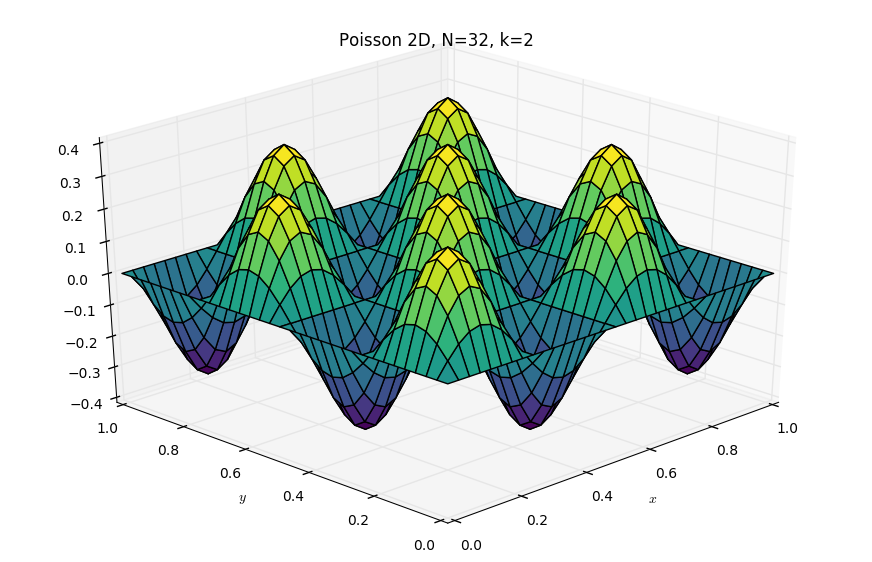

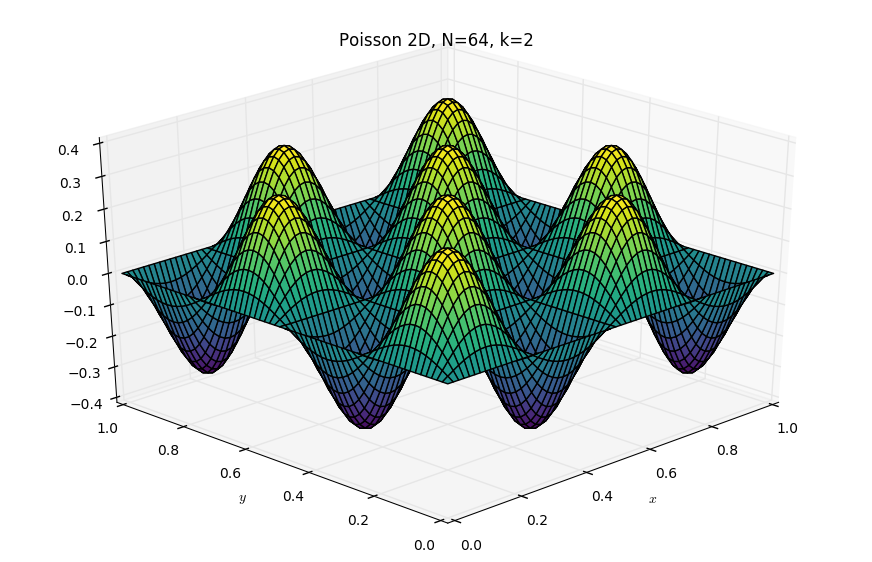

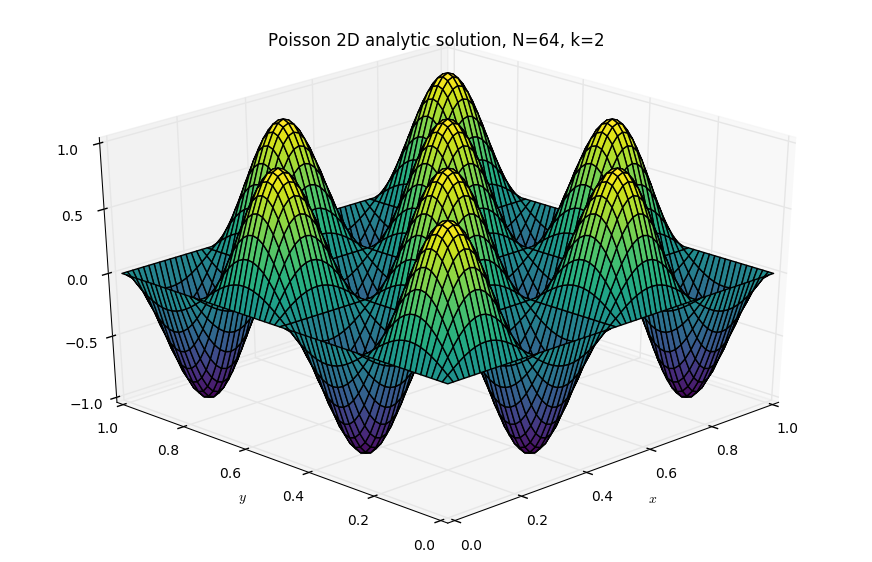

In [5]:
# Arrary and stuff
import numpy as np
import scipy.linalg as la
# We also need access to the colormaps for 3D plotting
from matplotlib import cm
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt

def fdm_poisson_2d_dense(N, k):
    '''A simple finite difference solver in 2d using a full matrix representation.'''

    # 1) Compute right hand side     
    
    # To define the grid we could use "linspace" as in Lab 1 to define subdivisions for the $x$ and $y$ axes.
    # But to make plotting easy and to vectorize the evaluation of the right-hand side $f$, we do something more fancy.
    # We define x and y coordinates for the grid using a "sparse grid" representation using the function 'ogrid'.
    # (Read the documentation for 'ogrid'!). Unfortunately, ogrid does not include the interval endpoints by 
    # default, but according to the numpy documentation, you can achieve this by multiplying your sampling number by
    # the pure imaginary number $i = \sqrt{-1}$  which is written as "1j" in Python code.
    # So simply speaking "(N+1)*1j" reads "include the end points" while (N+1) reads "exclude the end points".

    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    # Print x and y to see how they look like!
    #print(x)
    #print(y)
    
    # Evaluate f on the grid. 
    F_grid = 8*np.pi*k**2*np.sin(2*np.pi*k*x)*np.sin(2*np.pi*k*y)
    F_grid_inner = F_grid[1:N, 1:N]
    
    #You can print F_grid to verify that you got a 2 dimensional array
    # print(F_grid)
    
    # You can also plot F_grid now if you want :)
    # plot2D(x, y, F_grid, "f")
    
    # Now we define our rhs b by flattening out F, making it a 1 dimensional array of length (N+1)*(N+1). 
    F = F_grid_inner.ravel()  
    
    # 2) Create Matrix entries for unknowns associated with inner grid points. 
    
    # To translate the grid based double index into a proper numbering, we define a 
    # small mapping function, assuming a row-wise numbering. 
    # Drawing a picture of the grid and numbering the grid points in a row wise manner
    # helps to understand this mapping!
    def m(i,j):
        return i*(N-1) + j
    
    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N-1)**2
    
    # Allocate a (full!) MxM matrix filled with zeros
    A = np.zeros((M,M))
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(0,N-1):      # i is the row number for the grid point
        for j in range(0,N-1):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,m(i,j)] = 4/hh         # U_ij
            if i-1 >= 0:
                A[ri,m(i-1,j)] = -1/hh      # U_{i-1,j}
            if i+1 < N-1:
                A[ri,m(i+1,j)] = -1/hh      # U_{i+1,j}
            if j-1 >= 0:
                A[ri,m(i,j-1)] = -1/hh      # U_{i,j-1}
            if j+1 < N-1:
                A[ri,m(i,j+1)] = -1/hh      # U_{i,j+1}
    
    
    # 4) Solve linear systems
    # Solve linear algebra system 
    U = la.solve(A, F.T)
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid_inner = U.reshape((N-1,N-1))
    U_grid = np.zeros((N+1,N+1))
    U_grid[1:N,1:N] = U_grid_inner
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,F_grid,U_grid)

def plot2D(X, Y, Z, title=""):
    # Define a new figure with given size an
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z,             
                           rstride=1, cstride=1, # Sampling rates for the x and y input data
                           cmap=cm.viridis)      # Use the new fancy colormap viridis
    # Set initial view angle
    ax.view_init(30, 225)
    
    # Set labels and show figure
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    plt.show()
    
# Loop over different number of equally spaced subintervals
k = 2
for N in [8, 16, 32, 64]:
    x,y,F_grid,U_grid = fdm_poisson_2d_dense(N, k)
    plot2D(x, y, U_grid, 'Poisson 2D, N={}, k={}'.format(N, k))

U_real = np.sin(2*np.pi*k*x)*np.sin(2*np.pi*k*y)
plot2D(x, y, U_real, 'Poisson 2D analytic solution, N={}, k={}'.format(N, k))

### Code Snippets

As in Lab 1, places marked with $\ldots$ need you attention and must be filled with proper code.

We start with importing the necessary scientific libraries and define name aliases for them.

In [12]:
# Arrary and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm
# For 3D plotting
from mpl_toolkits.mplot3d import Axes3D

Next, we define a surface plotting function.

In [25]:
def plot2D(X, Y, Z, title=""):
    # Define a new figure with given size an
    fig = plt.figure(figsize=(11, 7), dpi=100)
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z,             
                           rstride=1, cstride=1, # Sampling rates for the x and y input data
                           cmap=cm.viridis)      # Use the new fancy colormap viridis
    # Set initial view angle
    ax.view_init(30, 225)
    
    # Set labels and show figure
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    plt.show()

Now the real fun begins. We will implement our FDM in a function which takes the number of subintervals $N$ and the frequency $k$ as arguments. We include a description of the function (A "docstring") at the beginning of the function. To get a feeling for the various data structure we are going to use, it might be helpful to print out a few of them and to look them up in the numpy/scipy documentation while you implementing the scheme!

In addition to the inbuilt documentation in the Spyder IDE, you can also look up things easily by scanning through the method/class index at
https://docs.scipy.org/doc/numpy/genindex.html

In [21]:
def fdm_poisson_2d_dense(N, k):
    '''A simple finite difference solver in 2d using a full matrix representation.'''

    # 1) Compute right hand side     
    
    # To define the grid we could use "linspace" as in Lab 1 to define subdivisions for the $x$ and $y$ axes.
    # But to make plotting easy and to vectorize the evaluation of the right-hand side $f$, we do something more fancy.
    # We define x and y coordinates for the grid using a "sparse grid" representation using the function 'ogrid'.
    # (Read the documentation for 'ogrid'!). Unfortunately, ogrid does not include the interval endpoints by 
    # default, but according to the numpy documentation, you can achieve this by multiplying your sampling number by
    # the pure imaginary number $i = \sqrt{-1}$  which is written as "1j" in Python code.
    # So simply speaking "(N+1)*1j" reads "include the end points" while (N+1) reads "exclude the end points".

    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    # Print x and y to see how they look like!
    #print(x)
    #print(y)
    
    # Evaluate f on the grid. 
    F_grid = np.sin(2*np.pi*k*x)*np.sin(2*np.pi*k*y)
    
    #You can print F_grid to verify that you got a 2 dimensional array
    # print(F_grid)
    
    # You can also plot F_grid now if you want :)
    # plot2D(x, y, F_grid, "f")
    
    # Now we define our rhs b by flattening out F, making it a 1 dimensional array of length (N+1)*(N+1). 
    F = F_grid.ravel()  
    
    # 2) Create Matrix entries for unknowns associated with inner grid points. 
    
    # To translate the grid based double index into a proper numbering, we define a 
    # small mapping function, assuming a row-wise numbering. 
    # Drawing a picture of the grid and numbering the grid points in a row wise manner
    # helps to understand this mapping!
    def m(i,j):
        return i*(N+1) + j
    
    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N+1)**2
    
    # Allocate a (full!) MxM matrix filled with zeros
    A = ...
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,m(i,j)] = 4/hh # U_ij
            A[ri,...] = -1/hh   # U_{i-1,j}
            A[...,...] = ...    # U_{i+1,j}
            A[...,...] = ...    # U_{i,j-1}
            A[...,...] = ...    # U_{i,j+1}
    
    # 3) Incorporate boundary conditions
    # Add boundary values related to unknowns from the first and last grid *ROW*
    for i in [0, N]:
        for j in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = ...
            A[...,...] = 1 # U_ij
            F[...] = 0     # b_{i,j}
    
    # Add boundary values related to unknowns from the first and last grid *COLUMN*
    ....
    
    # 4) Solve linear systems
    # Solve linear algebra system 
    U = ...
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid = U.reshape((N+1,N+1))
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,U_grid)

SyntaxError: invalid syntax (<ipython-input-21-9487caaaa789>, line 70)

**c**) Use the method of manufactured solution together with the given analytical reference solution $u_k$ to compute the experimental order of convergence (EOC)
for $N = 16, 32, 64$ using $\max_{i} |U-u|$ as error measure. Summarize your results in a table. 
What convergence rate do you get? If you don't get an EOC very close to $2$, find the bugs in your code :)

**d**) Test how large you can chose the resolution $N$ until either the problem takes too long (say 10 minutes) to compute or uses too much memory. Explain, what happens. Why does the problem
scale so badly with respect to $N$?

**e**) Based on your implementation from b), we now implement a finite difference using *sparse* matrices. Knowing the structure and entries of the matrix a priori, the most efficient 
realization would be based on (block) tridiagonal sparse matrices. 
But anticipating the forthcoming task of implementing schemes based on the finite element method, we will take a middle ground and simply switch to a flexible sparse matrix format which allows
for minimal adjustments of you previous solver implementation.
To this end you have incorporate the following code snippets into your code.

### Code Snippets

Get access to sparse matrices and sparse solvers.

In [ ]:
import scipy.sparse as sp
from scipy.sparse.linalg.dsolve import spsolve

Use a sparse matrix format for $A$, see https://docs.scipy.org/doc/scipy-0.18.1/reference/sparse.html
for the many formats which are available. Here we use "dictionary of keys" based representation which
is an empty matrix to begin with and which can easily filled with non-zero values at the appropriate
places.

In [ ]:
A = sp.dok_matrix((M, M))

After creating the matrix we have to convert it to a different format, the so-called
"Compressed Sparse Row matrix" representation, which is much more efficient when solving the system $A U = F$ with a sparse solver.

In [ ]:
# Now convert A to format which is more efficient for solving
A_csr = A.tocsr() 
U = spsolve(A_csr, F)

**f**) Measure and compare the overall solution time for your two implementations 'fdm_poisson_2d_dense' and 'fdm_poisson_2d_sparse' by using the cell magic command %%timeit.
Here is a simple example of its usage. Simply execute the next cell.

In [41]:
%%timeit # Measure execution time for entire cell, has to be at the top of the cell.

def compute_sum(N):
    sum = 0
    for i in range(0,N):
        sum += i
    return sum

N = 10000000
compute_sum(N)

1 loop, best of 3: 749 ms per loop


In [42]:
# If you want to measure execution time for a single line write %timeit instead
%timeit compute_sum(N)

1 loop, best of 3: 740 ms per loop


## Problem 2  (Ritz Galerkin Method)

**a)**
Using integration by parts, derive a weak formulation for the problem 
\begin{align*}
- (a(x)u(x)')' + c(x)u(x) = f \quad \text{in } I = (0,1)
\\
u(0) = g(0), \quad u(1) = g(1),
\end{align*}
for two smooth functions $a(x)$ and $c(x)$ satisfying $a(x) \geqslant a_0 > 0$
and $c(x) \geqslant 0$, and a boundary function $g: \{0,1\} \to \mathbb{R}$.
Note that the boundary values are not necessarily equal to $0$. Thus while the 
test functions $v$ are still supposed to be $0$ on the boundary of $I$, 
the definition of the function space for the solution/trial function $u$ needs to be adapted.

**b)** Recall that the Ritz-Galerkin method for numerically solving the two-point boundary value problem
\begin{align*}
- u'' = f \quad \text{in } I = (0,1)
\\
u(0) = 0, \quad u(1) = 0,
\end{align*}
is to find $u_h$ in a suitable discrete, finite dimensional subspace 
$V_{0,h} \subset V_0 = \left\{ v : \| v\|_{L^2(I)} + \| v'\|_{L^2(I)} < \infty, v(0) = v(1) = 0 \right \}$
such that for all $v \in V_{0,h}$
\begin{align*}
 \int_I u' v' \dx = \int_I f v \dx. 
\end{align*}
Given basis functions $\{\phi_i\}_{i=1}^N$ of $V_{0,h}$, show that the discrete weak formulation
is equivalent to requiring that 
\begin{align*}
 \int_I u' \phi_i' \dx = \int_I f \phi_i \dx, \quad i =1,\ldots,N. 
\end{align*}
holds.

**c)** Next, define the (inner) grid points $\{x_i\}_{i=1}^3 = \{ 0.25, 0.5, 0.75 \}$ for the
interval $[0,1]$ and let $\{\phi_i\}_{i=1}^3$ be the hat functions associated with 
$\{x_i\}_{i=1}^3$. Compute by hand the matrix $3\times 3$ matrix $A = (a_{ij})$ whose entry are given by
$$
a_{i j} = \int_0^1 \phi_j' \phi_i' \dx \quad i,j = 1,2,3.
$$
For the right-hand side $f(x) = x^2$ compute by hand the vector $F$ with
$$
F_i = \int_0^1 f \phi_i \dx, \quad i = 1, 2, 3
$$

Use the information from c) to find the finite element approximation $u_h(x) = \sum_{i=1}^3 U_i \phi(x)$ for the boundary value problem
\begin{gather}
- u''(x) = x^2 \quad x\in (0,1),
\\
u(0) = u(1) = 0
\end{gather}
by solving the linear algebra system $AU = b$.

**d)** (A glimpse at spectral methods)
We consider the periodic boundary value problem 
\begin{align*}
- u'' = f \quad \text{in } I = (0,2\pi)
\\
u(0) = u(2\pi)
\end{align*}
only assuming that the $u$ attains the same value on the left and right boundary point, but without knowing its actually value. Is that problem uniquely solvable?

Next, we introduce the function space $V_N$ which is spanned by the (periodic) trigonometric functions
$\{\cos(k x)\}_{k=0}^N \cup \{ \sin(k x)\}_{k=1}^N$, so we have $2N + 1$ basis functions
$\{\phi_i\}_{i=0}^{2N+1}$.  Compute the matrix $A$ defined by $a_{i j} = \int_0^1 \phi_j' \phi_i' \dx$ for general $N$.
(Hint: Either derive or look up integral formulas for integrals of the form $\int_0^{2\pi} cos(k x) sin(l x) dx$, $k,l \in \mathbb{N}$.
The resulting matrix should be particularly simple.

## Problem 3 (Interpolation)

**a)** For the interval $I = [-2,2] \subset \mathbb{R}$ and the three nodal point $\{\xi_i\}_0^2 = \{ -2, 0, 2\}$, calculate by hand the Lagrange basis functions $\{\lambda_i(x)\}_{i=0}^2$ of order $2$ satisfying 

$$
\lambda_i(\xi_j) =
\begin{cases}
1 &\quad \text{if } i=j
\\
0 &\quad\text{else}.
\end{cases}
$$.

**b)** Next, given $N+1$ uniformly distributed
nodes $\{\xi_i\}_{i=1}^N$ on $[-2,2]$ with $\xi_0 = -2$
$\xi_N = 2$, write a function which can compute and plot all Lagrange basis functions $\{\lambda_i\}_{i=0}^N$. To make your live easy, use the interpolation functionality baked into the scipy python module, see code snippets below.


**c)** Experiment with you brand new function and see how the Lagrange basis functions look like when you increase the order $N$. In particular, provide separate figures for $N = 3,4, 7,8, 11, 12$, where each figure shows a plot of all basis function $\{\lambda_i\}_{i=0}^N$ for that particular $N$ and the nodal point/nodal value pairs $\{(\xi_j,\delta_{ij})\}_{j=0}^N$.


**d)** For the $f(x) = e^{-8x^2}$, compute the $N$th-order Lagrange polynom $\pi^N f$ 
satisfying $(\pi^N f)(\xi_i) = f(\xi_i)$ for $i = 0, \ldots N$ and plot
both the exact $f$ and its Lagrange interpolant $\pi^N f$ for $N = 3,4,7,8,11,12$
with one figure for each $N$.
As before chose $I = [-2,2]$ and a uniform  nodes distribution which includes the 
end point of the $I$.
What can you say about the maximum error
$
\max_{x\in [-2,2]} | \pi^N f(x) - f(x)|
$
for increasning $N$?  Where does the error seem to concentrate?

**e)** Now repeat the experiment d) and c), but this time use as interpolation nodes the Chebyshev nodes which are defined by
$$
\xi_i = \dfrac{a+b}{2} + \dfrac{b - a}{2} \cos\left(\tfrac{i}{N}\pi\right)  
$$
on a general interval $[a,b]$. The Chebyshev nodes are precisely the nodes, which minimizes
the expression
$$
\max_{x\in[a,b]} |(x-\xi_0)(x-\xi_1)\cdots(x - \xi_{N-1})(x- \xi_N))|
$$
which appeared in the error estimate of the Lagrange interpolation.
Describe the main differences
when using uniform node distribution compared to Chebyshev node distribution.

### Hints and Code Snippets


Interpolation functionality can be found in the module scipy.interpolate module,
see https://docs.scipy.org/doc/scipy-0.18.1/reference/interpolate.html
and the short examples in the nice tutorial at 
http://www.scipy-lectures.org/intro/scipy.html#interpolation-scipy-interpolate

In [ ]:
import scipy.interpolate as ip

Lagrange interpolation polynom can be computed like this.

In [23]:
# x_nodes is a 1 dimensional array containing the nodal points
# nodal_values is a 1 dimensional array containing the values of the
# function to be interpolated at the nodal points
L = ip.lagrange(x_nodes,nodal_values)

Observe that you can compute the Lagrange basis functions $\lambda_i$ associated
with node $\xi_i$ by simply passing a "nodal_values" array which is $1$ for index $i$ and $0$ otherwise.

There is also a scipy function which compute a continuous piecewise linear interpolation function for given nodes and nodal values.

In [ ]:
f_inter = ip.interp1d(...,...)

Finally, for the plotting the various interpolation polynoms and functions, you should use a much higher resolution/sampling rate, since the inbuilt plotting routines usually just do a simple piecewise interpolation between the given grid points and function values.

The following cell loads non-default styles for the notebook.

In [24]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)

# Comment out next line and execute this cell to restore the default notebook style 
css_styling()